In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
from data_types import AuthorsDB
from data_types import PublicationsDB
from data_types import AbstractsDB


## Load Data

In [3]:
audb = AuthorsDB()
audb.load()
pubdb = PublicationsDB()
pubdb.load()
absdb = AbstractsDB()
absdb.load()

filename = "../data/mathnet_iam_authors_dict.pkl"
with open(filename,'rb') as inp:
    authors_dict = pickle.load(inp)

# EDA

Plan for the EDA to answer these questions:
- How many authors are we trying to get and how many have we already received?
- How many papers abstracts we already received?
- What are distributions by years: 
  - published papers
  - ?
- What are distributions by author:
  - number of papers,
  - number of coauthors,
  - ?

# 1 Simple questions about data 
Count All and None values

## 1.1 Databases  

### 1.1.1 Authors data structures
 - authors_dict - Name and mathnet_id
 - audb - Author and his papers

In [4]:
for ind, person in authors_dict.items():
    if ind<6:
        print(person)

{'name': 'Абалакин Илья Владимирович', 'mn_id': '29400'}
{'name': 'Авдуевский Всеволод Сергеевич', 'mn_id': '25875'}
{'name': 'Агапов Владимир Михайлович', 'mn_id': '79709'}
{'name': 'Агафонов С И', 'mn_id': '37981'}
{'name': 'Агаян В М', 'mn_id': '39797'}


In [5]:
mn_id = "29400"
for ind, item in enumerate(audb.db['29400']):
    if ind < 4:
        print(ind)
        print(item)
        print(audb.db['29400'][item])    

0
mm4353
{'year': '2022', 'nrf': 2}
1
mm4312
{'year': '2021', 'nrf': 2}
2
zvmmf11279
{'year': '2021', 'nrf': 1}
3
crm838
{'year': '2020', 'nrf': 1}


Number of authors

In [6]:
print(f"Number of received authors {len(audb.db.keys())}")
print(f"Number of authors in list  {len(authors_dict.keys())}")
print(f"Percent of received authors = {round(100*(len(audb.db.keys())/len(authors_dict.keys())),1)}%")

Number of received authors 871
Number of authors in list  871
Percent of received authors = 100.0%


### 1.1.2 Pandas DataFrame with main publication info

In [7]:
pub = pd.DataFrame.from_dict(pubdb.db,orient='index')

In [8]:
pub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7597 entries, vyurv213 to vmumm4420
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author_id  7597 non-null   object
 1   doi        1624 non-null   object
 2   udk        3119 non-null   object
 3   send       2844 non-null   object
 4   type       5398 non-null   object
 5   reference  7597 non-null   object
 6   by         7081 non-null   object
 7   paper      7081 non-null   object
 8   jour       7025 non-null   object
 9   yr         7081 non-null   object
 10  vol        4534 non-null   object
 11  issue      4605 non-null   object
 12  pages      4707 non-null   object
dtypes: object(13)
memory usage: 830.9+ KB


In [9]:
pub.head()

,author_id,doi,udk,send,type,reference,by,paper,jour,yr,vol,issue,pages
vyurv213,"[113970, 148811, 22428]","<a class=""SLink"" href=""https://doi.org/10.1452...",004.052.3,20.11.2018,Статья,,"А.~А.~Бондаренко, П.~А.~Ляхов, М.~В.~Якобовский",Координированное сохранение с журналированием ...,Вестн. ЮУрГУ. Сер. Выч. матем. информ.,2019,8,2,76--91
vyurv1,"[113970, 22428]","<a class=""SLink"" href=""https://doi.org/10.1452...",004.052.3,13.04.2015,Статья,,"А.~А.~Бондаренко, М.~В.~Якобовский",Моделирование отказов в высокопроизводительных...,Вестн. ЮУрГУ. Сер. Выч. матем. информ.,2015,4,3,5--12
vyurv46,"[113970, 22428]",None,004.052.3,05.08.2014,Статья,,"А.~А.~Бондаренко, М.~В.~Якобовский",Обеспечение отказоустойчивости высокопроизводи...,Вестн. ЮУрГУ. Сер. Выч. матем. информ.,2014,3,3,20--36
ipmp2988,"[25339, 26426, 31779, 26427]",:https://doi.org/10.20948/prepr-2021-71,None,None,Препринт,"С. В. Поляков, М. А. Трапезникова, А. Г. Чурба...","С.~В.~Поляков, М.~А.~Трапезникова, А.~Г.~Чурба...",Расчет несжимаемых течений в системе &lt;&lt;п...,Препринты ИПМ им.~М.~В.~Келдыша,2021,None,None,None
ipmp2939,"[101245, 25339, 163334]",:https://doi.org/10.20948/prepr-2021-21,None,None,Препринт,"Б. Г. Фрейнкман, С. В. Поляков, И. О. Толстов,...","Б.~Г.~Фрейнкман, С.~В.~Поляков, И.~О.~Толстов",Расчет основного состояния электрона в неоднор...,Препринты ИПМ им.~М.~В.~Келдыша,2021,None,None,None


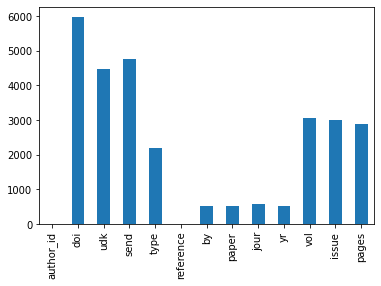

In [10]:
pub.isnull().sum().plot(kind='bar');

### 1.1.3 Pandas DataFrame with abstracts

In [11]:
absdb.db.head()

,abstract,keywords
mn_link,,
vyurv213,Увеличивающийся рост числа компонент суперкомп...,"расширение ULFM, контрольные точки, координиро..."
vyurv1,Рассматривается проблема выполнения длительных...,"параллельные вычисления, отказоустойчивость, к..."
vyurv46,"Рассматриваются вопросы, связанные с проведени...","параллельные вычисления, отказоустойчивость, к..."
ipmp2988,В данной работе рассмотрена модель для сопряже...,"модель Бринкмана, уравнения Навье-Стокса, своб..."
ipmp2939,Данное исследование связано с разработкой мате...,"математическое моделирование, решетка графена,..."


In [12]:
absdb.db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7597 entries, vyurv213 to vmumm4420
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   abstract  5609 non-null   object
 1   keywords  2525 non-null   object
dtypes: object(2)
memory usage: 178.1+ KB


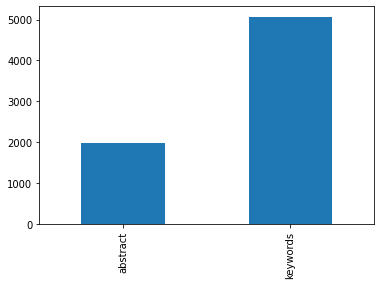

In [13]:
absdb.db.isnull().sum().plot(kind='bar');

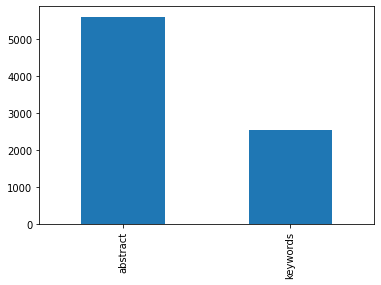

In [14]:
absdb.db.notnull().sum().plot(kind='bar');

In [15]:
for ind,val in enumerate(absdb.db[absdb.db.notnull()].index):
    if ind<10:
        print(val)

vyurv213
vyurv1
vyurv46
ipmp2988
ipmp2939
mm4253
danma122
vmp992
ipmp2783
ipmp2734


In [16]:
(pub.loc[list(absdb.db[absdb.db.notnull()].index)]['yr']>'2005').sum()

3302

In [17]:
print('1998'>'2005')
print('2008'>'2005')

False
True


## 1.2 Publications and their artefacts

In [18]:
print(f"Number of received papers is       {len(absdb.db.index)}")
print(f"Number of papers without abstracts {(absdb.db['abstract'].isnull()).sum()}")
print(f"Number of papers without keywords  {(absdb.db['keywords'].isnull()).sum()}")

Number of received papers is       7597
Number of papers without abstracts 1988
Number of papers without keywords  5072


Look through papers with artefacts 

In [19]:
w_year = 0
new_count = 0
old_count = 0
breaking_year = 2008
links_to_check = ['http://mi.mathnet.ru/'+mn_link for mn_link in absdb.db.index[absdb.db['abstract'].isnull()]]
for link, slink in zip(links_to_check, absdb.db.index[absdb.db['abstract'].isnull()]):
    year = pub.loc[slink,'yr']    
    if year is None:
        # print(f"year = {year}, name = {pub.loc[slink,'paper']}, link = {link} ")
        w_year+=1
    else:
        if int(year)>breaking_year:    
            new_count +=1
            print(f"year = {year},  link = {link}, name = {pub.loc[slink,'paper']}, ")
        else:
            old_count +=1
print(f"Numper of papers without abstracts without 'year' field is {w_year}")
print(f"Count of NEW papers without abstracts {new_count}")
print(f"Count of OLD papers without abstracts {old_count}")


year = 2021,  link = http://mi.mathnet.ru/mm4267, name = Памяти Николая Николаевича Калиткина, 
year = 2018,  link = http://mi.mathnet.ru/mm3935, name = Памяти Александра Сергеевича Холодова, 
year = 2017,  link = http://mi.mathnet.ru/crm91, name = Памяти Александра Сергеевича Холодова (11.10.1941 -- 05.11.2017), 
year = 2017,  link = http://mi.mathnet.ru/svmo668, name = Юрий Николаевич Дерюгин~--- к семидесятилетию со дня рождения, 
year = 2016,  link = http://mi.mathnet.ru/mm3685, name = Памяти О.\,М.~Белоцерковского, 
year = 2016,  link = http://mi.mathnet.ru/zvmmf10413, name = Памяти академика Российской академии наук Олега Михайловича Белоцерковского, 
year = 2016,  link = http://mi.mathnet.ru/zvmmf10334, name = Памяти профессора Алексея Владимировича Гулина (26.03.1942--27.03.2015), 
year = 2015,  link = http://mi.mathnet.ru/mm3614, name = Международная молодежная конференция &lt;&lt;Современные проблемы прикладной математики и информатики&gt;&gt;, 
year = 2015,  link = http://mi